# Energetic Forecast with Prophet

In [1]:
# basic functionalities
import datetime
import itertools

# data transforamtion and manipulation
import pandas as pd
import numpy as np
import pandas_profiling

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Prophet modeling libaries
from fbprophet import Prophet
# metrics 
from random import random
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.metrics import median_absolute_error, mean_squared_log_error

# Importing data
- Dataset: Electricity consumption in the state of PMJ
- Unit: Mega Watt: MW
- Hourly timestamp 
 

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/energy_cons.png" width="1000">

In [2]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/PJME_hourly.csv

--2021-05-18 17:15:40--  https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/PJME_hourly.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.194
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070265 (3.9M) [text/csv]
Saving to: ‘PJME_hourly.csv’

PJME_hourly.csv     100%[===================>]   3.88M  6.21MB/s    in 0.6s    

2021-05-18 17:15:41 (6.21 MB/s) - ‘PJME_hourly.csv’ saved [4070265/4070265]



In [4]:
df = pd.read_csv('PJME_hourly.csv')
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


## __Converting to datetime format and sort:__

In [5]:
# convert: 
df['Datetime'] = pd.to_datetime(df['Datetime'])
# sort:
df.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)

# renaming the target variable columns
df.rename(columns={'PJME_MW':'Consumption [MW]'}, inplace=True)
df

,Datetime,Consumption [MW]
8734,2002-01-01 01:00:00,30393.0
8735,2002-01-01 02:00:00,29265.0
8736,2002-01-01 03:00:00,28357.0
8737,2002-01-01 04:00:00,27899.0
8738,2002-01-01 05:00:00,28057.0
...,...,...
140250,2018-08-02 20:00:00,44057.0
140251,2018-08-02 21:00:00,43256.0
140252,2018-08-02 22:00:00,41552.0
140253,2018-08-02 23:00:00,38500.0


## __Removal duplicates__:

In [6]:
#keep only the last measurement for datetime
df.drop_duplicates(subset='Datetime', keep='last', inplace=True)

## __Setting index as the datetime column for easier manipulations:__

In [7]:
df = df.set_index('Datetime')
df

,Consumption [MW]
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


__Note:__
- datetime index's frequency is None => there are some missing data points somewhere (otherwise Python could deduce it) => remove missing 

## __Find and Fill Missing datetime Instances__

In [8]:
# ideal range: without missing data
date_range = pd.date_range(start=min(df.index), end=max(df.index), freq='H')

In [9]:
#Reindex the dataset and then fill data:

#Create null values in missing data:
df = df.reindex(date_range)

#Filling  missing  with linear interpolation between existing data points
df['Consumption [MW]'].interpolate(method='linear', inplace=True)

# now we have a neatly continuous datetime index
print(f'The df.index.freq is now: {df.index.freq}, => we no have missing instances')


The df.index.freq is now: <Hour>, => we no have missing instances


## Extracting Time Features

- We split datetime into its different __features__ => to find patterns for different groups.

In [11]:
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['weekofyear'] = df.index.weekofyear
df['dayofmonth'] = df.index.day # Day of Month
df['date'] = df.index.date 

# let's add the season number
df['season'] = df['month'].apply(lambda month_number: (month_number%12 + 3)//3)

In [12]:
df

,Consumption [MW],dayofweek,dayofyear,year,month,quarter,hour,weekday,weekofyear,dayofmonth,date,season
2002-01-01 01:00:00,30393.0,1,1,2002,1,1,1,1,1,1,2002-01-01,1
2002-01-01 02:00:00,29265.0,1,1,2002,1,1,2,1,1,1,2002-01-01,1
2002-01-01 03:00:00,28357.0,1,1,2002,1,1,3,1,1,1,2002-01-01,1
2002-01-01 04:00:00,27899.0,1,1,2002,1,1,4,1,1,1,2002-01-01,1
2002-01-01 05:00:00,28057.0,1,1,2002,1,1,5,1,1,1,2002-01-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,3,214,2018,8,3,20,3,31,2,2018-08-02,3
2018-08-02 21:00:00,43256.0,3,214,2018,8,3,21,3,31,2,2018-08-02,3
2018-08-02 22:00:00,41552.0,3,214,2018,8,3,22,3,31,2,2018-08-02,3
2018-08-02 23:00:00,38500.0,3,214,2018,8,3,23,3,31,2,2018-08-02,3


# Forecasting metrics


In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y_true,y_pred):
    results = pd.DataFrame({'r2_score':r2_score(y_true-np.median(y_true), y_pred-np.median(y_pred))}, 
                           index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y_true, y_pred)
    results['median_absolute_error'] = median_absolute_error(y_true, y_pred)
    results['mse'] = mean_squared_error(y_true, y_pred)
    results['msle'] = mean_squared_log_error(y_true, y_pred)
    results['mape'] = mean_absolute_percentage_error(y_true, y_pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

# Long Term Forecasting

## Train and Test split

In [14]:
y    = df['Consumption [MW]']
df.index.min(),df.index.max()

(Timestamp('2002-01-01 01:00:00', freq='H'),
 Timestamp('2018-08-03 00:00:00', freq='H'))

In [15]:
t_train_start = '2013-01-01'
t_train_end   = '2016-12-31'
 
# splitting
y_train = y.loc[(y.index >= t_train_start) & (y.index <= t_train_end)].copy()
y_test  = y.loc[(y.index >  t_train_end)].copy()
y       = y_train.append(y_test) 


In [16]:
y_train.index.min(), y_train.index.max(), y_test.index.min(), y_test.index.max(),

(Timestamp('2013-01-01 00:00:00', freq='H'),
 Timestamp('2016-12-31 00:00:00', freq='H'),
 Timestamp('2016-12-31 01:00:00', freq='H'),
 Timestamp('2018-08-03 00:00:00', freq='H'))

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                         mode='lines',
                         name='Train'))

fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                         mode='lines', 
                         name='Test'))

# adjust layout
fig.update_layout(title='Train/Test Split',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

## Long Term forecasting with ETS models: Triple Exponential Smoothing  

 
### Holt-Winters’ Additive Method
 

In [19]:
from statsmodels.tsa.api import ExponentialSmoothing
# exponential smoothing only takes into consideration patterns in the target variable:

#fit
holt_winter = ExponentialSmoothing(y_train,
                                   seasonal_periods=24*365,
                                   seasonal='add').fit()
#predict:
yp_hw_add = holt_winter.forecast(len(y_test))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [20]:
print('Holt-Winters’ Additive Method:')
ef=evaluate_forecast(y_test, yp_hw_add)
ef

Holt-Winters’ Additive Method:


,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.199909,4436.731314,3487.697348,3.304447e+07,0.029586,14.526622,5748.431672


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                         mode='lines',
                         name='Train'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                         mode='lines', 
                         name='Test'))

fig.add_trace(go.Scatter(x=yp_hw_add.index, y=yp_hw_add,
                         mode='lines', 
                         name='yp_hw_add'))
# adjust layout
fig.update_layout(title="Holt-Winter Additive Model, Forecasting of Hourly Energy Demand:  MAPE=%2.3f%%"%ef['mape'],
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

Output hidden; open in https://colab.research.google.com to view.



### Holt-Winters’ Multiplicative Method


In [23]:
# exponential smoothing only takes into consideration patterns in the target variable:
#fit
holt_winter = ExponentialSmoothing(y_train,
                                          seasonal_periods=24*365,
                                          seasonal='mul').fit()
#predict:
yp_hw_mul = holt_winter.forecast(len(y_test))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [24]:
print('Holt-Winters’ Multiplicative Method:')
ef=evaluate_forecast(y_test, yp_hw_mul)
ef

Holt-Winters’ Multiplicative Method:


,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.220337,4144.06565,3340.932334,2.926935e+07,0.027152,13.262385,5410.11592


In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                         mode='lines',
                         name='Train'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                         mode='lines', 
                         name='Test'))

fig.add_trace(go.Scatter(x=yp_hw_mul.index, y=yp_hw_mul,
                         mode='lines', 
                         name='yp_hw_mul'))
# adjust layout
fig.update_layout(title="Holt-Winter Multiplicative Model, Forecasting of Hourly Energy Demand:  MAPE=%2.3f%%"%ef['mape'],
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

Output hidden; open in https://colab.research.google.com to view.

## Long Term forecasting with Prophet


## The Prophet Forecasting Model

Prophet was developed by Facebook and released as open source in 2017: [https://facebook.github.io/prophet/]

The library utilizes the [additive regression model](https://en.wikipedia.org/wiki/Additive_model) $y(t)$ comprising the following components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon(t)$$

where:
* Trend $g(t)$ models non-periodic changes : __piecewise linear__ or __logistic growth__ curve for modelling non-periodic changes in time series
* Seasonality $s(t)$ represents periodic changes (e.g. weekly/yearly seasonality)
* Holidays component $h(t)$ contributes information about holidays and events effects of holidays (user provided) with irregular schedules.

 
### Trend

The Prophet library implements two possible trend models for $g(t)$.

- *Nonlinear, Saturating Growth*. It is represented in the form of the [logistic growth model](https://en.wikipedia.org/wiki/Logistic_function):

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$

- *Piecewise Linear Model* with a constant rate of growth. It is best suited for problems without saturating growth.

### Seasonality

The seasonal component $s(t)$ provides a flexible model of periodic changes due to daily weekly and yearly seasonality. Prophet relies on Fourier series to model seasonality:
* A **higher order** fits the sine wave more closely to the seasonality in the data, at the risk of capturing too much of the noise __overfitting__
* A **lower order** smoothes out the noise, at the risk of not capturing enough of the seasonality __underfitting__

A good, general fit lies in between: try to find this by Prophet's built-in cross-validation method.
 
 

### Holidays and Events

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.


### Error

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.






In [27]:
# format data for prophet model using 'ds' and 'y'
train_prophet = pd.DataFrame(y_train).reset_index().rename(columns={
                                                                     'index':'ds', 
                                                                     'Consumption [MW]':'y'
                                                                   })

test_prophet = pd.DataFrame(y_test).reset_index().rename(columns={
                                                                   'index':'ds', 
                                                                   'Consumption [MW]':'y'
                                                                 })


In [28]:
train_prophet.head()

,ds,y
0,2013-01-01 00:00:00,29864.0
1,2013-01-01 01:00:00,28386.0
2,2013-01-01 02:00:00,27250.0
3,2013-01-01 03:00:00,26252.0
4,2013-01-01 04:00:00,25755.0


In [29]:
test_prophet.head()

,ds,y
0,2016-12-31 01:00:00,29627.0
1,2016-12-31 02:00:00,28744.0
2,2016-12-31 03:00:00,28274.0
3,2016-12-31 04:00:00,28162.0
4,2016-12-31 05:00:00,28434.0


In [30]:
# instantiating the class with custom settings, for the sake of illustration
model = Prophet( daily_seasonality  = True,
                   weekly_seasonality = True,
                   yearly_seasonality = True,
                   seasonality_mode   ='additive',
                 )

# fitting the model
model.fit(train_prophet);

# drop y: is part of the dataframe on which we want to make predictions
future = test_prophet.drop(['y'], axis=1)

# predicting values
forecast = model.predict(future)

In [31]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-12-31 01:00:00,32637.568907,22673.308848,31800.256489,32637.568907,32637.568907,-5438.542010,-5438.542010,-5438.542010,-4137.094946,-4137.094946,-4137.094946,-514.999218,-514.999218,-514.999218,-786.447846,-786.447846,-786.447846,0.0,0.0,0.0,27199.026897
1,2016-12-31 02:00:00,32637.902014,21237.862281,30235.161416,32637.902014,32637.902014,-6936.436022,-6936.436022,-6936.436022,-5526.033399,-5526.033399,-5526.033399,-630.393551,-630.393551,-630.393551,-780.009072,-780.009072,-780.009072,0.0,0.0,0.0,25701.465991
2,2016-12-31 03:00:00,32638.235121,20575.664629,29399.904831,32638.235121,32638.235121,-7854.017634,-7854.017634,-7854.017634,-6331.077079,-6331.077079,-6331.077079,-749.401770,-749.401770,-749.401770,-773.538786,-773.538786,-773.538786,0.0,0.0,0.0,24784.217486
3,2016-12-31 04:00:00,32638.568228,20090.054301,29084.153541,32638.568228,32638.568228,-8064.523735,-8064.523735,-8064.523735,-6425.959960,-6425.959960,-6425.959960,-871.526683,-871.526683,-871.526683,-767.037092,-767.037092,-767.037092,0.0,0.0,0.0,24574.044492
4,2016-12-31 05:00:00,32638.901335,20866.401827,29657.823148,32638.901335,32638.901335,-7473.706223,-7473.706223,-7473.706223,-5716.979093,-5716.979093,-5716.979093,-996.223033,-996.223033,-996.223033,-760.504096,-760.504096,-760.504096,0.0,0.0,0.0,25165.195112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13915,2018-08-02 20:00:00,37272.753058,7631.171893,92688.861836,-3549.315609,81895.234656,10823.932006,10823.932006,10823.932006,4368.993870,4368.993870,4368.993870,841.383034,841.383034,841.383034,5613.555101,5613.555101,5613.555101,0.0,0.0,0.0,48096.685064
13916,2018-08-02 21:00:00,37273.086165,5740.901623,91186.764197,-3554.965877,81898.382028,9982.966771,9982.966771,9982.966771,3543.958177,3543.958177,3543.958177,833.602391,833.602391,833.602391,5605.406202,5605.406202,5605.406202,0.0,0.0,0.0,47256.052936
13917,2018-08-02 22:00:00,37273.419272,4986.658904,89753.315438,-3560.616145,81901.529401,8362.015000,8362.015000,8362.015000,1939.029624,1939.029624,1939.029624,825.694864,825.694864,825.694864,5597.290512,5597.290512,5597.290512,0.0,0.0,0.0,45635.434272
13918,2018-08-02 23:00:00,37273.752379,2451.328265,88308.299709,-3566.266413,81904.676773,6263.672126,6263.672126,6263.672126,-142.943543,-142.943543,-142.943543,817.407369,817.407369,817.407369,5589.208300,5589.208300,5589.208300,0.0,0.0,0.0,43537.424505


In [32]:
print('Prophet Additive Model:')
ef=evaluate_forecast(test_prophet.y, forecast.yhat)
ef

Prophet Additive Model:


,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.444169,5069.920954,4639.907326,3.661311e+07,0.034367,17.221264,6050.876752


In [33]:
fig = go.Figure()

# draw confidence bound (gray)
fig.add_trace(go.Scatter(x=forecast.ds, 
                         y=forecast.yhat_lower,
                         fill=None,
                         mode='lines',
                         name='Upper CI',
                         line_color='lightpink',
                        ))
fig.add_trace(go.Scatter(
                        x=forecast.ds, 
                        y=forecast.yhat_upper,
                        fill='tonexty', # fill area between trace0 and trace1
                        mode='lines', 
                        name='Lower CI',
                        line_color='lightpink'
                        ))

fig.add_trace(go.Scatter(x=train_prophet.ds, 
                         y=train_prophet.y,
                         mode='lines',
                         name='Train',
                         line_color='blue',
                        ))

fig.add_trace(go.Scatter(x=test_prophet.ds, 
                         y=test_prophet.y,
                         mode='lines',
                         name='Test',
                         line_color='blue',
                        ))

fig.add_trace(go.Scatter(x=forecast.ds, 
                         y=forecast.yhat,
                         mode='lines',
                         name='Forecast',
                         line_color='red',
                        ))


# adjust layout
fig.update_layout(title=f'Prophet Forecast of Hours of Energy Demand:  MAPE=%2.3f%%'%ef['mape'],
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

Output hidden; open in https://colab.research.google.com to view.

In [34]:
# format data for prophet model using 'ds' and 'y'
train_test_prophet = pd.DataFrame(y).reset_index().rename(columns={
                                                                     'index':'ds', 
                                                                     'Consumption [MW]':'y'
                                                                   })
# predicting training and test values
train_test_forecast = model.predict(train_test_prophet)
train_test_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01 00:00:00,31392.853043,25079.010538,34470.721425,31392.853043,31392.853043,-1665.463051,-1665.463051,-1665.463051,-2280.423269,-2280.423269,-2280.423269,1245.540785,1245.540785,1245.540785,-630.580568,-630.580568,-630.580568,0.0,0.0,0.0,29727.389992
1,2013-01-01 01:00:00,31393.244026,23454.137245,32156.506681,31393.244026,31393.244026,-3486.796719,-3486.796719,-3486.796719,-4137.094946,-4137.094946,-4137.094946,1273.744029,1273.744029,1273.744029,-623.445801,-623.445801,-623.445801,0.0,0.0,0.0,27906.447307
2,2013-01-01 02:00:00,31393.635008,22378.942722,31159.185383,31393.635008,31393.635008,-4845.037355,-4845.037355,-4845.037355,-5526.033399,-5526.033399,-5526.033399,1297.278296,1297.278296,1297.278296,-616.282252,-616.282252,-616.282252,0.0,0.0,0.0,26548.597653
3,2013-01-01 03:00:00,31394.025990,21233.560209,30340.989515,31394.025990,31394.025990,-5623.672146,-5623.672146,-5623.672146,-6331.077079,-6331.077079,-6331.077079,1316.494986,1316.494986,1316.494986,-609.090053,-609.090053,-609.090053,0.0,0.0,0.0,25770.353844
4,2013-01-01 04:00:00,31394.416973,20969.083325,30219.298702,31394.416973,31394.416973,-5696.071547,-5696.071547,-5696.071547,-6425.959960,-6425.959960,-6425.959960,1331.757753,1331.757753,1331.757753,-601.869340,-601.869340,-601.869340,0.0,0.0,0.0,25698.345425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48956,2018-08-02 20:00:00,37272.753058,2501.911032,92419.979894,-7267.178015,81199.916784,10823.932006,10823.932006,10823.932006,4368.993870,4368.993870,4368.993870,841.383034,841.383034,841.383034,5613.555101,5613.555101,5613.555101,0.0,0.0,0.0,48096.685064
48957,2018-08-02 21:00:00,37273.086165,1896.995116,92491.714876,-7273.095128,81202.919783,9982.966771,9982.966771,9982.966771,3543.958177,3543.958177,3543.958177,833.602391,833.602391,833.602391,5605.406202,5605.406202,5605.406202,0.0,0.0,0.0,47256.052936
48958,2018-08-02 22:00:00,37273.419272,-12.414455,90007.256210,-7279.012241,81205.922782,8362.015000,8362.015000,8362.015000,1939.029624,1939.029624,1939.029624,825.694864,825.694864,825.694864,5597.290512,5597.290512,5597.290512,0.0,0.0,0.0,45635.434272
48959,2018-08-02 23:00:00,37273.752379,-260.743904,87135.999722,-7284.929354,81208.925781,6263.672126,6263.672126,6263.672126,-142.943543,-142.943543,-142.943543,817.407369,817.407369,817.407369,5589.208300,5589.208300,5589.208300,0.0,0.0,0.0,43537.424505


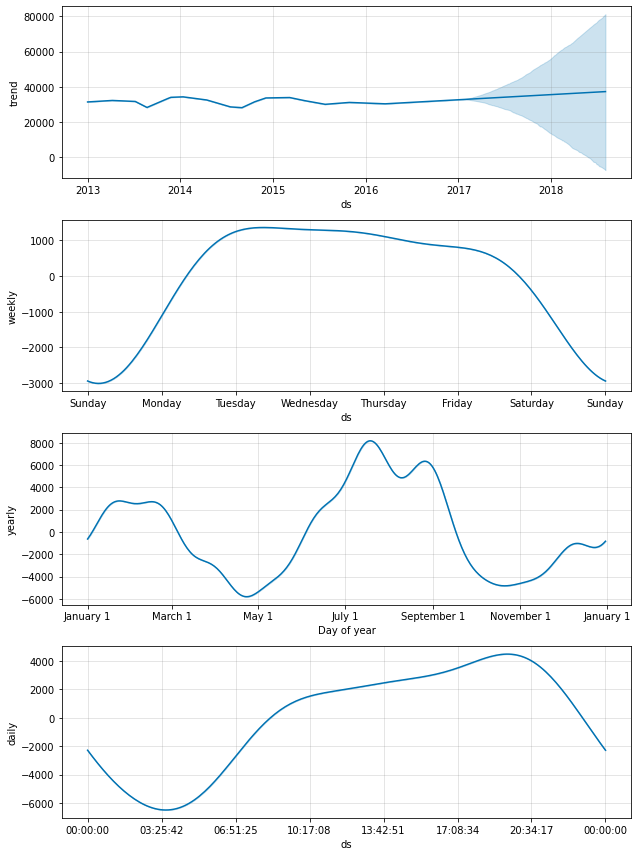

In [35]:
fig = model.plot_components(train_test_forecast);

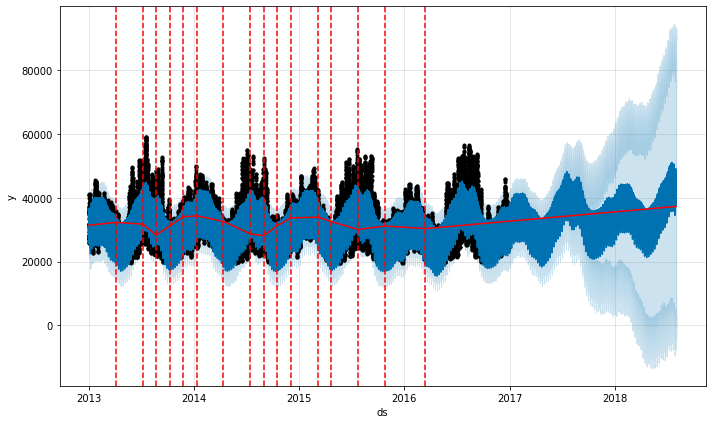

In [36]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(train_test_forecast);
add_changepoints_to_plot(fig.gca(), model, train_test_forecast);

## CONCLUSIONI

- __DAY feature:__ Energy consumption dipende dalle giornate lavorativi e dai week-end
- __HOLIDAY feature:__ Le vacanze modificano l'energy consumption (meno gente lavora)
- __SEASON feature:__ Ci sono 4 picchi stagionali




